<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Name-Biswajit gorai ,Roll no- MA24M005

In [ ]:
#

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bgorai005 (bgorai005-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


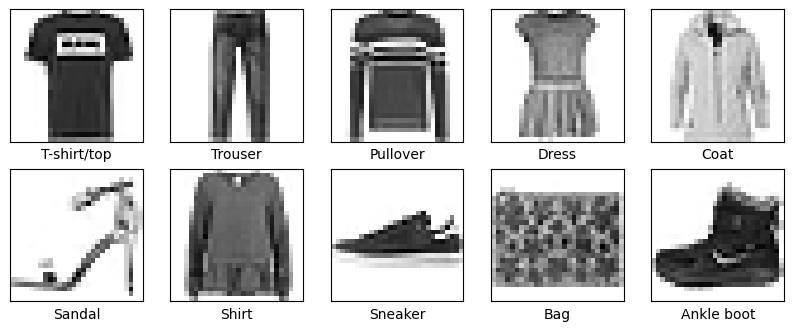

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning_assignment_1',name='dataset_samples',mode='online')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"examples":[wandb.Image(train_images[i],caption=class_labels[train_labels[i]])for i in range(10)]})
# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()
#594642013968a68e466138e783dcece6765c43b9

In [59]:
from sklearn.model_selection import train_test_split

def tranform_dataset(train_images,train_labels,test_images,test_labels):
  #split the training dataset for traning and validation
  x_train,x_valid,y_train,y_valid=train_test_split(train_images,train_labels,test_size=0.1,random_state=42)
   #flattenten the image data
  x_train = x_train.reshape(x_train.shape[0], -1)
  x_valid = x_valid.reshape(x_valid.shape[0], -1)
  x_test = test_images.reshape(test_images.shape[0], -1)
  #Normalize the image data
  x_train = x_train.astype('float32') / 255
  x_valid = x_valid.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # one hot encode for output column
  y_train = one_hot_encode(y_train)
  y_valid = one_hot_encode(y_valid)
  y_test = one_hot_encode(test_labels)


  return x_train,y_train,x_valid,y_valid,x_test,y_test



#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded


In [60]:
#transform the dataset for using the feedforward neural network models
x_train,y_train,x_valid,y_valid,x_test,y_test=tranform_dataset(train_images,train_labels,test_images,test_labels)

In [61]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


Intialize a network

In [62]:
import numpy as np

def initial_weight(num_layer, hidden_size, weight_ini_method):
    # Create a list with num_layer hidden layers, each of size hidden_size
    network_size = [hidden_size] * num_layer
    # Prepend input size and append output size
    network_size = [x_train.shape[1]] + network_size + [y_train.shape[1]]
    print(network_size)  # Print the network architecture for debugging

    # Initialize an empty dictionary to store weights and biases
    theta = {}

    # Random initialization
    if weight_ini_method == "random":
        for i in range(len(network_size) - 1):
            # Weights: shape (current layer size, next layer size)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1])
            # Biases: shape (1, next layer size)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1])

    # Xavier (He-like) initialization
    elif weight_ini_method == "Xavier":
        for i in range(len(network_size) - 1):
            # Scaling factor based on input size (fan-in)
            scale = np.sqrt(2 / network_size[i])
            # Weights: random normal scaled by sqrt(2 / fan-in)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1]) * scale
            # Biases: random normal scaled by sqrt(2 / fan-in)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1]) * scale

    # Return the initialized parameters
    return theta

*Activation functiont**

In [63]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [64]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss
def mse_loss(y_actual,y_pred):
  return np.mean((y_actual-y_pred)**2)

In [65]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


In [66]:
# theta=initial_weight(5,[5]*5,"random")
# _,_,y_pred=forward_prop(x_train,theta,"sigmoid",'softmax',5)
# print(y_pred)

Calculate accuracy

In [67]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [68]:
def back_prop(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
  m=x.shape[0]
  a,h,y_pred=forward_prop(x,theta,active_fun_hidden,active_fun_output,num_layers)
  grad_theta={}
  grad_h_a={}
  grad_h_a[f'a{num_layers+1}']=(y_pred-y)
  for i in range(num_layers+1,0,-1):
    grad_theta[f'W{i}']=np.dot(h[f'h{i-1}'].T,grad_h_a[f'a{i}'])
    grad_theta[f'b{i}']=np.sum(grad_h_a[f'a{i}'],axis=0,keepdims=True)

    if i>1:
      grad_h_a[f'h{i-1}']=np.dot(grad_h_a[f'a{i}'],theta[f'W{i}'].T)
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*deriv_activation(a[f'a{i-1}'],active_fun_hidden)
  return grad_theta

Now we again write gradient decesent algorithm compatiable with batch size ,

In [69]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [70]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})



    return theta


**Nesterov accelerated gradient descent**

In [71]:
def nesterov_gd(lr, momentum, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entorpy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers)

            # Update velocities and parameters with Nesterov momentum and apply weight decay
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}'] + weight_decay * theta[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity (no weight decay for biases)
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss and predictions
        a, h, y_train_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100,'epoch':epoch+1})

    return theta, loss_history, val_loss_history

**RMS Prop**

In [72]:
def rmsprop(lr, gamma, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method,weight_decay, epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros, matching the shape of each parameter
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store training and validation loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update squared gradients and parameters with RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Update weights using RMSprop
                theta[f'W{k}'] -= lr * (grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon) + weight_decay * theta[f'W{k}'])

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases using RMSprop
                theta[f'b{k}'] -= lr * grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon)

       #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_train_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1 }, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100,'epoch':epoch+1})



    return theta


**ADAM**

In [73]:
def adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    return theta


**NDAM**

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100,'epoch':epoch})



    return theta


**MOdel **

In [ ]:
def model_training(lr, beta, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, optimizer, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function):

    if optimizer == 'sgd':
        theta = sgd(lr, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'momentum':
        theta = mgd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'nag':
        theta = nesterov_gd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'RMSprop':
        theta = rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer == 'adam':
        theta = adam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    elif optimizer=='nadam':
      theta=nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entopy')
    return theta

In [ ]:
#Q2 and Q3 train a neural network with given hypermaters with cross entropy loss
#in question 2 intialize a neural network and pass a forward prop that will predict probabilities. here i run adam model , in there first it create
#a intial network and call backprop update weights , in back prop at first it will call forward prop then update weights and it will iterate as many epochs it has
#and give the accuracy, loss for train and valid dataset.
#---------uncomment the below code for run----------------
#wandb.init(project='deep_learning_assignment_1',name='adam-relu-softmax-random-layer-4-hid_size-32-epoch-5'')
#theta=adam(0.001,0.9,0.99,1e-8,x_train, y_train, x_valid, y_valid,32,4,'relu','softmax','random',0,5)
#wandb.finish()


In [ ]:
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: xd33zmtu
Sweep URL: https://wandb.ai/bgorai005-iit-madras/deep_learning_assignment_1/sweeps/xd33zmtu


In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs)

try:
    wandb.agent(sweep_id,function=main,count=40)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: xbn030cc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.4335385714741053, Val Loss: 0.4472559765764906
Epoch 2, Train Loss: 0.4333111003661983, Val Loss: 0.4490536660993083
Epoch 3, Train Loss: 0.37875115980568397, Val Loss: 0.3987406362118386
Epoch 4, Train Loss: 0.35738869607959856, Val Loss: 0.3841254939456394
Epoch 5, Train Loss: 0.34899578215711285, Val Loss: 0.37593500609748964
Test accuracy: 0.853


epoch,▁▃▅▆█
train_accuracy,▃▁▆▇█
train_loss,██▃▂▁
val_accuracy,▃▁▆▆█
val_loss,██▃▂▁
epoch,5
train_accuracy,87.25741
train_loss,0.349
val_accuracy,86.68333
val_loss,0.37594


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9r1hgq4c with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 9.53329456563213, Validation Loss: 0.4238189482673716
Epoch 2, Loss: 11.333162936737269, Validation Loss: 0.4160223926869669
Epoch 3, Loss: 11.876498850229972, Validation Loss: 0.35825566833340783
Epoch 4, Loss: 12.516838058668997, Validation Loss: 0.3824886145440105
Epoch 5, Loss: 13.021505979062768, Validation Loss: 0.35996167496016157
Epoch 6, Loss: 13.29742265380877, Validation Loss: 0.34679078612860287
Epoch 7, Loss: 14.189812414566125, Validation Loss: 0.356150329704876
Epoch 8, Loss: 14.89230534460388, Validation Loss: 0.367934966924619
Epoch 9, Loss: 14.95657877339094, Validation Loss: 0.34551391530708475
Epoch 10, Loss: 14.507271820141034, Validation Loss: 0.3433344448704371
 accuracy: 0.8664


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▄▆▇▇▆▇█
train_loss,▁▃▄▅▆▆▇██▇
val_accuracy,▁▁▆▅▆▇▆▅██
val_loss,█▇▂▄▂▁▂▃▁▁
epoch,10
train_accuracy,89.79444
train_loss,14.50727
val_accuracy,88.06667
val_loss,0.34333


wandb: Agent Starting Run: apzfd9ml with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.45202467581435835, Val Loss: 0.46452980540056116
Epoch 2, Train Loss: 0.39978143762139823, Val Loss: 0.4189221837939364
Epoch 3, Train Loss: 0.3993331148549371, Val Loss: 0.41932255062887996
Epoch 4, Train Loss: 0.3490458086917652, Val Loss: 0.3746798302882706
Epoch 5, Train Loss: 0.33586238124522005, Val Loss: 0.3663364671280317
Epoch 6, Train Loss: 0.36755025711969397, Val Loss: 0.410911847243589
Epoch 7, Train Loss: 0.3434591890696666, Val Loss: 0.3854415320557101
Epoch 8, Train Loss: 0.31604710733905494, Val Loss: 0.36095119862413994
Epoch 9, Train Loss: 0.29573050437766296, Val Loss: 0.34248008695762217
Epoch 10, Train Loss: 0.3316017248810285, Val Loss: 0.39061802964900894
Test accuracy: 0.8544


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▆▄▆▇█▆
train_loss,█▆▆▃▃▄▃▂▁▃
val_accuracy,▁▄▃▅▆▄▅▆█▆
val_loss,█▅▅▃▂▅▃▂▁▄
epoch,10
train_accuracy,87.8963
train_loss,0.3316
val_accuracy,86.5
val_loss,0.39062


wandb: Agent Starting Run: jnmfwt2e with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 31.03316843946913, Validation Loss: 14.487500734119365
Epoch 2, Loss: 30.983832133957495, Validation Loss: 12.88831555385545
Epoch 3, Loss: 31.049409366668073, Validation Loss: 12.21152652730433
Epoch 4, Loss: 31.06546014760979, Validation Loss: 11.611871177321074
Epoch 5, Loss: 31.14247242241098, Validation Loss: 11.351139051939851
 accuracy: 0.6759


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▃▁▄▅█
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,68.51296
train_loss,31.14247
val_accuracy,66.88333
val_loss,11.35114


wandb: Agent Starting Run: x4lut4fi with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 2.8509875052562896, Val Loss: 2.9087032744537367
Epoch 2, Train Loss: 2.009556617505747, Val Loss: 2.0273369546529527
Epoch 3, Train Loss: 1.648853335113416, Val Loss: 1.7241275021319051
Epoch 4, Train Loss: 1.4484605138315423, Val Loss: 1.5411871849834708
Epoch 5, Train Loss: 1.3181958943858014, Val Loss: 1.4092953613806625
Test Accuracy: 59.53000000000001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y2jkas3h with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.3166489965973014, Val Loss: 1.3421847109797098
Epoch 2, Train Loss: 1.1148488466890871, Val Loss: 1.1335591571234893
Epoch 3, Train Loss: 1.0808335288340873, Val Loss: 1.0936039390834111
Epoch 4, Train Loss: 0.9354993508572383, Val Loss: 0.9567335808359979
Epoch 5, Train Loss: 0.9135715193244007, Val Loss: 0.9253284167661324
Test Accuracy: 65.93


wandb: Agent Starting Run: jynjb5a5 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 31.00367021650215, Validation Loss: 7.862003763293087
Epoch 2, Loss: 30.90627383460012, Validation Loss: 7.221717985672981
Epoch 3, Loss: 30.85638120636756, Validation Loss: 6.965105546055456
Epoch 4, Loss: 30.825322170735834, Validation Loss: 6.712591216786604
Epoch 5, Loss: 30.784495146259832, Validation Loss: 7.065313034761442
 accuracy: 0.7648


epoch,▁▃▅▆█
train_accuracy,▁▆▆█▆
train_loss,█▅▃▂▁
val_accuracy,▂█▇▇▁
val_loss,█▄▃▁▃
epoch,5
train_accuracy,79.38889
train_loss,30.7845
val_accuracy,76.08333
val_loss,7.06531


wandb: Agent Starting Run: 3qttgp58 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 3.30071067040283, Validation Loss: 1.3543099991698462
Epoch 2, Loss: 4.129934269082031, Validation Loss: 1.0717493287835849
Epoch 3, Loss: 4.5327437696229085, Validation Loss: 0.8949403209541338
Epoch 4, Loss: 5.045800435940473, Validation Loss: 0.7932392404585051
Epoch 5, Loss: 5.367018450610292, Validation Loss: 0.71914207395434
 accuracy: 0.7454


epoch,▁▃▅▆█
train_accuracy,▁▂▆▇█
train_loss,▁▄▅▇█
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,75.57593
train_loss,5.36702
val_accuracy,74.78333
val_loss,0.71914


wandb: Agent Starting Run: idr5hty4 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 2.274691498269505, Val Loss: 2.2758509656374146
Epoch 2, Train Loss: 2.238456670467317, Val Loss: 2.239069988435424
Epoch 3, Train Loss: 2.171659458348459, Val Loss: 2.1739672284903024
Epoch 4, Train Loss: 2.0376796984855376, Val Loss: 2.0414404364487435
Epoch 5, Train Loss: 1.8406101899232723, Val Loss: 1.8471528354188516
Test Accuracy: 43.169999999999995


wandb: Agent Starting Run: udu3mkf2 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1 + np.exp(-x))


Epoch 1, Loss: 0.09054650146412269, Validation Loss: 0.09063952083502409
Epoch 2, Loss: 0.09093093455390899, Validation Loss: 0.09083552660138965
Epoch 3, Loss: 0.09112062074287987, Validation Loss: 0.09105875362737137
Epoch 4, Loss: 0.09176632156405565, Validation Loss: 0.09154936697702133
Epoch 5, Loss: 0.09068216539074028, Validation Loss: 0.09057870280449795
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,█▄▄▁▁
train_loss,▁▃▄█▂
val_accuracy,▁▅▅██
val_loss,▁▃▄█▁
epoch,5
train_accuracy,9.95
train_loss,0.09068
val_accuracy,10.45
val_loss,0.09058


wandb: Agent Starting Run: x32berst with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.0662380432055074, Val Loss: 1.0610921009531378
Epoch 2, Train Loss: 0.9335290972303073, Val Loss: 0.9465378574029155
Epoch 3, Train Loss: 0.8596796427820141, Val Loss: 0.8851494663452706
Epoch 4, Train Loss: 0.8196811827482754, Val Loss: 0.8388301586414227
Epoch 5, Train Loss: 0.7807570267977839, Val Loss: 0.8122945183861003
Test Accuracy: 70.55


wandb: Agent Starting Run: e1l4w2jf with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.1057291491341645, Val Loss: 1.1258496879926396
Epoch 2, Train Loss: 0.8644305771052195, Val Loss: 0.894012293043637
Epoch 3, Train Loss: 0.775580280401691, Val Loss: 0.8047184545264578
Epoch 4, Train Loss: 0.7277044259314556, Val Loss: 0.7574065710688189
Epoch 5, Train Loss: 0.6694112667737574, Val Loss: 0.6977561067599205
Epoch 6, Train Loss: 0.6521862461942454, Val Loss: 0.6727456691291384
Epoch 7, Train Loss: 0.625931607781181, Val Loss: 0.6721430473380073
Epoch 8, Train Loss: 0.607056151327304, Val Loss: 0.640216904376438
Epoch 9, Train Loss: 0.5874094447459529, Val Loss: 0.6289760279048963
Epoch 10, Train Loss: 0.5709461527693627, Val Loss: 0.6045742904403903
Test accuracy: 0.7798


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.80741
train_loss,0.57095
val_accuracy,79.1
val_loss,0.60457


wandb: Agent Starting Run: onlr3k70 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 13.684830078788252, Validation Loss: 0.4783642316457837
Epoch 2, Loss: 14.767307087957521, Validation Loss: 0.45571140780558966
Epoch 3, Loss: 18.955866810746738, Validation Loss: 0.4868938744924542
Epoch 4, Loss: 19.814146642410318, Validation Loss: 0.6760861553736437
Epoch 5, Loss: 19.423627836464195, Validation Loss: 0.6044070309589625
Epoch 6, Loss: 21.506033865371744, Validation Loss: 0.6097773225437121
Epoch 7, Loss: 20.940117860818244, Validation Loss: 0.5016309031038033
Epoch 8, Loss: 19.27183457007979, Validation Loss: 0.7114184539769514
Epoch 9, Loss: 21.343242420065422, Validation Loss: 0.7064010919251184
Epoch 10, Loss: 19.790297183477623, Validation Loss: 0.6304972820854948
Test accuracy: 0.7854


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▇█▅▃▆█▁▅▁
train_loss,▁▂▆▆▆█▇▆█▆
val_accuracy,▅▇█▆▄▅█▁▅▁
val_loss,▂▁▂▇▅▅▂██▆
epoch,10
train_accuracy,80.11667
train_loss,19.7903
val_accuracy,78.96667
val_loss,0.6305


wandb: Agent Starting Run: ks05kiz6 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.5428300629494345, Val Loss: 1.5815886297944355
Epoch 2, Train Loss: 1.0609116849514788, Val Loss: 1.0682678657861
Epoch 3, Train Loss: 0.9102291457522936, Val Loss: 0.9516678780278531
Epoch 4, Train Loss: 0.8245475197854111, Val Loss: 0.8647280342064613
Epoch 5, Train Loss: 0.7737831652937539, Val Loss: 0.8163563870919418
Test accuracy: 0.7075


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▃▂▁▁
epoch,5
train_accuracy,71.72593
train_loss,0.77378
val_accuracy,71
val_loss,0.81636


wandb: Agent Starting Run: 04a4kdyl with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 10.87375330841626, Val Loss: 11.274245559341296
Epoch 2, Train Loss: 9.716286670717293, Val Loss: 10.085322707313919
Epoch 3, Train Loss: 9.201674814149401, Val Loss: 9.667025385686973
Epoch 4, Train Loss: 8.911416827130942, Val Loss: 9.408654188878842
Epoch 5, Train Loss: 8.54624016946789, Val Loss: 9.064465248394301
Test accuracy: 0.731


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,75.23889
train_loss,8.54624
val_accuracy,73.73333
val_loss,9.06447


wandb: Agent Starting Run: xerav6vm with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 8.139422584573405, Validation Loss: 1.3760334746559209
Epoch 2, Loss: 8.437806040417497, Validation Loss: 1.015753063794753
Epoch 3, Loss: 8.565327560041938, Validation Loss: 0.8990584569256225
Epoch 4, Loss: 8.759336102764044, Validation Loss: 0.836388945952012
Epoch 5, Loss: 8.735937934407307, Validation Loss: 0.7987318826719229
 accuracy: 0.7237


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▄▆██
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,74.39444
train_loss,8.73594
val_accuracy,72.58333
val_loss,0.79873


wandb: Agent Starting Run: 0pc5pa34 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 13.04758344678722, Validation Loss: 4.721349836763211
Epoch 2, Loss: 10.945021966079409, Validation Loss: 2.7682640448710916
Epoch 3, Loss: 9.052041454004002, Validation Loss: 1.758598147166032
Epoch 4, Loss: 8.724381485288124, Validation Loss: 1.2933124696228244
Epoch 5, Loss: 8.52739527364218, Validation Loss: 1.1413267119659576
Test accuracy: 0.5881


epoch,▁▃▅▆█
train_accuracy,▁▃▄▆█
train_loss,█▅▂▁▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,59.30741
train_loss,8.5274
val_accuracy,58.1
val_loss,1.14133


wandb: Agent Starting Run: 33gf96tk with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 6.440021831823253, Validation Loss: 0.41002620860707867
Epoch 2, Loss: 6.835927793542052, Validation Loss: 0.40119860802216334
Epoch 3, Loss: 7.138888866253165, Validation Loss: 0.35539385444387295
Epoch 4, Loss: 7.466147156285812, Validation Loss: 0.34036938263908184
Epoch 5, Loss: 7.66909812928296, Validation Loss: 0.35540577348637603
 accuracy: 0.8648


epoch,▁▃▅▆█
train_accuracy,▁▂▅██
train_loss,▁▃▅▇█
val_accuracy,▁▁▅█▆
val_loss,█▇▃▁▃
epoch,5
train_accuracy,89.02778
train_loss,7.6691
val_accuracy,86.96667
val_loss,0.35541


wandb: Agent Starting Run: 8ksswvy7 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 7.461314187365576, Validation Loss: 0.5186397261577704
Epoch 2, Loss: 8.320487464076978, Validation Loss: 0.4608794563635472
Epoch 3, Loss: 8.842326669263178, Validation Loss: 0.43250033177467184
Epoch 4, Loss: 9.115862719963443, Validation Loss: 0.41399458953353935
Epoch 5, Loss: 9.384153384541438, Validation Loss: 0.40195179126088854
Epoch 6, Loss: 9.6379052590697, Validation Loss: 0.39703995441865353
Epoch 7, Loss: 9.789279327061704, Validation Loss: 0.3896361599166767
Epoch 8, Loss: 9.938226090797283, Validation Loss: 0.3786902886552193
Epoch 9, Loss: 10.086489858547033, Validation Loss: 0.3770969169287525
Epoch 10, Loss: 10.087555560754291, Validation Loss: 0.3719665162100958
 accuracy: 0.8604


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▆▇▇██
train_loss,▁▃▅▅▆▇▇███
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.93148
train_loss,10.08756
val_accuracy,87.11667
val_loss,0.37197


wandb: Agent Starting Run: 9ini2zub with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 2.885868395955922, Validation Loss: 1.299030296930577
Epoch 2, Loss: 3.564465579048604, Validation Loss: 0.943726342578529
Epoch 3, Loss: 4.033793020110647, Validation Loss: 0.7728241198635942
Epoch 4, Loss: 4.438865324162616, Validation Loss: 0.6792847915064975
Epoch 5, Loss: 4.711537760028959, Validation Loss: 0.6208929318211172
 accuracy: 0.7761


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▄▅▇█
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,78.72222
train_loss,4.71154
val_accuracy,78.01667
val_loss,0.62089


wandb: Agent Starting Run: exrtdzlg with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.5392850477348656, Val Loss: 0.5554192487556593
Epoch 2, Train Loss: 0.4386242293611668, Val Loss: 0.4578683658942902
Epoch 3, Train Loss: 0.3992268544344314, Val Loss: 0.42602527886377306
Epoch 4, Train Loss: 0.3583258715535974, Val Loss: 0.3861876621864389
Epoch 5, Train Loss: 0.34070680874387355, Val Loss: 0.37000644974587643
Epoch 6, Train Loss: 0.3519913769634565, Val Loss: 0.39630397908449244
Epoch 7, Train Loss: 0.3462502747244055, Val Loss: 0.38751673921967966
Epoch 8, Train Loss: 0.3044903470037733, Val Loss: 0.35830208708652217
Epoch 9, Train Loss: 0.3414637141212407, Val Loss: 0.38713792956121096
Epoch 10, Train Loss: 0.3036715974225757, Val Loss: 0.35686732958584466
Test accuracy: 0.8628


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇▇█▇█
train_loss,█▅▄▃▂▂▂▁▂▁
val_accuracy,▁▄▅▆▇▇▇█▇█
val_loss,█▅▃▂▁▂▂▁▂▁
epoch,10
train_accuracy,88.9037
train_loss,0.30367
val_accuracy,87.51667
val_loss,0.35687


wandb: Agent Starting Run: thfu9etc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]


<ipython-input-8-867b69375f18>:20: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x,axis=1,keepdims=True)


Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Test Accuracy: 10.0


wandb: Agent Starting Run: gjkcop4u with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.47446056268590664, Val Loss: 0.4845738483043633
Epoch 2, Train Loss: 0.4367980162869416, Val Loss: 0.45133054109755155
Epoch 3, Train Loss: 0.4276032577454806, Val Loss: 0.45730039314884213
Epoch 4, Train Loss: 0.36597689634586755, Val Loss: 0.3960277099014398
Epoch 5, Train Loss: 0.37400271657630607, Val Loss: 0.4179684783613276
Test accuracy: 0.8485


epoch,▁▃▅▆█
train_accuracy,▁▃▂▇█
train_loss,█▆▅▁▂
val_accuracy,▁▂▁▇█
val_loss,█▅▆▁▃
epoch,5
train_accuracy,87.1037
train_loss,0.374
val_accuracy,86
val_loss,0.41797


wandb: Agent Starting Run: xmljdcnc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.15136026113072448, Validation Loss: 0.15194865188112644
Epoch 2, Loss: 0.13712684495035196, Validation Loss: 0.13827667463238744
Epoch 3, Loss: 0.172162149246056, Validation Loss: 0.1682039763335212
Epoch 4, Loss: 0.17816893928308747, Validation Loss: 0.18000756574617235
Epoch 5, Loss: 0.1778582111851814, Validation Loss: 0.179694885118478
Epoch 6, Loss: 0.1469104540208526, Validation Loss: 0.14844208947592177
Epoch 7, Loss: 0.12057639194353316, Validation Loss: 0.12158853772640883
Epoch 8, Loss: 0.1371820463950541, Validation Loss: 0.13770452137663147
Epoch 9, Loss: 0.13652344130734054, Validation Loss: 0.1369751949853397
Epoch 10, Loss: 0.14871049097013178, Validation Loss: 0.14918703319955307
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃█▂▂▂▂▂▂▂
train_loss,▅▃▇██▄▁▃▃▄
val_accuracy,▂▄█▁▁▁▁▃▃▃
val_loss,▅▃▇██▄▁▃▃▄
epoch,10
train_accuracy,10.02407
train_loss,0.14871
val_accuracy,9.78333
val_loss,0.14919


wandb: Agent Starting Run: f5922fls with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.8503795307279051, Val Loss: 0.8590620367269612
Epoch 2, Train Loss: 0.8966426025041343, Val Loss: 0.9262033635405275
Epoch 3, Train Loss: 0.7571107995706324, Val Loss: 0.7652723317570963
Epoch 4, Train Loss: 0.7957022344596407, Val Loss: 0.8076831064436456
Epoch 5, Train Loss: 0.6821544278072976, Val Loss: 0.7069941861969207
Test accuracy: 0.7508


epoch,▁▃▅▆█
train_accuracy,▂▁▇▇█
train_loss,▆█▃▅▁
val_accuracy,▃▁███
val_loss,▆█▃▄▁
epoch,5
train_accuracy,76.0537
train_loss,0.68215
val_accuracy,74.16667
val_loss,0.70699


wandb: Agent Starting Run: helr5kub with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 7.167799734773712, Validation Loss: 0.4096097933829885
Epoch 2, Loss: 7.477181586248949, Validation Loss: 0.37450360149196066
Epoch 3, Loss: 8.053404363310984, Validation Loss: 0.3538197410666288
Epoch 4, Loss: 8.076853256781485, Validation Loss: 0.3260440087013798
Epoch 5, Loss: 8.350510898588649, Validation Loss: 0.33883489777523607
 accuracy: 0.8685


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,▁▃▆▆█
val_accuracy,▁▃▅█▆
val_loss,█▅▃▁▂
epoch,5
train_accuracy,89.08519
train_loss,8.35051
val_accuracy,87.85
val_loss,0.33883


wandb: Agent Starting Run: pkuhppr9 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 5.213083437526773, Validation Loss: 1.2428486324991437
Epoch 2, Loss: 5.387105512058871, Validation Loss: 0.9997093979234135
Epoch 3, Loss: 5.556789679553177, Validation Loss: 0.9124289298970973
Epoch 4, Loss: 5.623511550220844, Validation Loss: 0.8638130517888314
Epoch 5, Loss: 5.706732132337128, Validation Loss: 0.8178178410762476
 accuracy: 0.6861


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,▁▃▆▇█
val_accuracy,▁▄▆▆█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,69.84815
train_loss,5.70673
val_accuracy,69.66667
val_loss,0.81782


wandb: Agent Starting Run: n3qxstua with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 5.725296227697104, Validation Loss: 0.432760592676646
Epoch 2, Loss: 6.1786887754265, Validation Loss: 0.3832794156764261
Epoch 3, Loss: 6.36194319838858, Validation Loss: 0.3787666428266193
Epoch 4, Loss: 6.543561386565097, Validation Loss: 0.35518133275910924
Epoch 5, Loss: 6.748981361288608, Validation Loss: 0.34921277296001735
Epoch 6, Loss: 6.845744634999279, Validation Loss: 0.34014755992352497
Epoch 7, Loss: 6.8785186449198585, Validation Loss: 0.33451875113612045
Epoch 8, Loss: 6.999773129385286, Validation Loss: 0.33583553797125404
Epoch 9, Loss: 7.1519676620451165, Validation Loss: 0.3290960884917016
Epoch 10, Loss: 7.250020539226659, Validation Loss: 0.32634878341092916
 accuracy: 0.8691


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▇▇▇██
train_loss,▁▃▄▅▆▆▆▇██
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,89.62778
train_loss,7.25002
val_accuracy,88.01667
val_loss,0.32635


wandb: Agent Starting Run: kqodbdlu with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.6538053911789994, Val Loss: 1.6531153728335752
Epoch 2, Train Loss: 1.3052962492696538, Val Loss: 1.3061063814273015
Epoch 3, Train Loss: 1.1184917364636657, Val Loss: 1.1194282665140949
Epoch 4, Train Loss: 1.0061510204196087, Val Loss: 1.0057351609509135
Epoch 5, Train Loss: 0.933502167366311, Val Loss: 0.9343461629610589
Epoch 6, Train Loss: 0.8823074220322774, Val Loss: 0.8844505731017925
Epoch 7, Train Loss: 0.8425956668939424, Val Loss: 0.8448185198294392
Epoch 8, Train Loss: 0.810851475033908, Val Loss: 0.813771400698343
Epoch 9, Train Loss: 0.7842414222122237, Val Loss: 0.7880081039671165
Epoch 10, Train Loss: 0.7617194564718458, Val Loss: 0.7655671237445937
Test accuracy: 0.7254


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,73.37593
train_loss,0.76172
val_accuracy,72.15
val_loss,0.76557


wandb: Agent Starting Run: rj1ieiu9 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 3.2027487683869054, Validation Loss: 1.3202698782023345
Epoch 2, Loss: 4.212112261967574, Validation Loss: 0.9673439432891969
Epoch 3, Loss: 4.95778065549623, Validation Loss: 0.7574240684061225
Epoch 4, Loss: 5.5936323114383235, Validation Loss: 0.6367765731182549
Epoch 5, Loss: 6.041986103275417, Validation Loss: 0.5748922950553675
Test accuracy: 0.7838


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▃▅▇█
val_accuracy,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,79.27593
train_loss,6.04199
val_accuracy,78.16667
val_loss,0.57489


wandb: Agent Starting Run: 8vf80vad with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 2.289132446834749, Val Loss: 2.2939107260860885
Epoch 2, Train Loss: 1.7470325781373337, Val Loss: 1.746327146841346
Epoch 3, Train Loss: 2.12826754745798, Val Loss: 2.1294452753784965
Epoch 4, Train Loss: 1.8048962136572289, Val Loss: 1.8234040771374493
Epoch 5, Train Loss: 2.7192911394671015, Val Loss: 2.7268936675691138
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▆█▅▇▁
train_loss,▅▁▄▁█
val_accuracy,▆█▅▆▁
val_loss,▅▁▄▂█
epoch,5
train_accuracy,10.02407
train_loss,2.71929
val_accuracy,9.78333
val_loss,2.72689


wandb: Agent Starting Run: gldnk1ye with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.4107978952987612, Val Loss: 0.42640898163369534
Epoch 2, Train Loss: 0.34715221171783694, Val Loss: 0.37917583691053336
Epoch 3, Train Loss: 0.35513022152570894, Val Loss: 0.3866672960117037
Epoch 4, Train Loss: 0.30027634033071887, Val Loss: 0.34436215448451524
Epoch 5, Train Loss: 0.2921127542347969, Val Loss: 0.345154327133831
Epoch 6, Train Loss: 0.28718521087947363, Val Loss: 0.3492437490343559
Epoch 7, Train Loss: 0.27164182329897146, Val Loss: 0.33929224562569577
Epoch 8, Train Loss: 0.28127767535741716, Val Loss: 0.3550679536211905
Epoch 9, Train Loss: 0.2705062646517946, Val Loss: 0.3552377557835528
Epoch 10, Train Loss: 0.24867324031274912, Val Loss: 0.33851043411982296
Test accuracy: 0.8764


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▃▆▆▆▇▆▇█
train_loss,█▅▆▃▃▃▂▂▂▁
val_accuracy,▁▄▃▆▇▇▇▆▆█
val_loss,█▄▅▁▂▂▁▂▂▁
epoch,10
train_accuracy,90.89444
train_loss,0.24867
val_accuracy,88.31667
val_loss,0.33851


wandb: Agent Starting Run: fo74c9bl with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.6154744400343868, Val Loss: 1.623362587740966
Epoch 2, Train Loss: 1.1441029720123685, Val Loss: 1.1530246989254265
Epoch 3, Train Loss: 0.9196982504677412, Val Loss: 0.9281454421711972
Epoch 4, Train Loss: 0.7540904694979006, Val Loss: 0.7633963392881234
Epoch 5, Train Loss: 0.6468779918687236, Val Loss: 0.655668881711867
Test accuracy: 0.7607


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,77.34074
train_loss,0.64688
val_accuracy,76.55
val_loss,0.65567


wandb: Agent Starting Run: 6ynv43aw with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 9.085875417214304, Validation Loss: 0.4118361465686155
Epoch 2, Loss: 9.907154205553981, Validation Loss: 0.35596906113528093
Epoch 3, Loss: 10.849941851430284, Validation Loss: 0.35866069458003424
Epoch 4, Loss: 11.283126409525298, Validation Loss: 0.3327098855578608
Epoch 5, Loss: 11.842539180274699, Validation Loss: 0.33893150253117504
Epoch 6, Loss: 12.603585311147901, Validation Loss: 0.3666751388048018
Epoch 7, Loss: 13.211001575585485, Validation Loss: 0.3436447896986659
Epoch 8, Loss: 14.006393254871256, Validation Loss: 0.3307720400616371
Epoch 9, Loss: 13.476307809718318, Validation Loss: 0.32089610206644803
Epoch 10, Loss: 14.042279556871039, Validation Loss: 0.32617697822817715
 accuracy: 0.8786


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▆▆▅▆▇██
train_loss,▁▂▃▄▅▆▇█▇█
val_accuracy,▁▅▅▇▆▄▇▇██
val_loss,█▄▄▂▂▅▃▂▁▁
epoch,10
train_accuracy,91.21667
train_loss,14.04228
val_accuracy,88.63333
val_loss,0.32618


wandb: Agent Starting Run: w68n1auh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.1684894766212841, Validation Loss: 0.16704524289293593
Epoch 2, Loss: 0.16270635218235094, Validation Loss: 0.16125245765157378
Epoch 3, Loss: 0.1489096683920143, Validation Loss: 0.1499360765694832
Epoch 4, Loss: 0.1373682500610546, Validation Loss: 0.1335838790964387
Epoch 5, Loss: 0.17018003223684977, Validation Loss: 0.17414368939228553
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▄▅▁█▄
train_loss,█▆▃▁█
val_accuracy,▅▅▁█▁
val_loss,▇▆▄▁█
epoch,5
train_accuracy,10.09259
train_loss,0.17018
val_accuracy,9.16667
val_loss,0.17414


wandb: Agent Starting Run: 2i6ox6mc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Epoch 6, Train Loss: nan, Val Loss: nan
Epoch 7, Train Loss: nan, Val Loss: nan
Epoch 8, Train Loss: nan, Val Loss: nan
Epoch 9, Train Loss: nan, Val Loss: nan
Epoch 10, Train Loss: nan, Val Loss: nan
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: t4ve4t2a with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.5710982151948595, Val Loss: 0.5794619640991191
Epoch 2, Train Loss: 0.5471592580169856, Val Loss: 0.5681994823542829
Epoch 3, Train Loss: 0.4887016307044027, Val Loss: 0.5180642705877285
Epoch 4, Train Loss: 0.5156184761752522, Val Loss: 0.5482079286028724
Epoch 5, Train Loss: 0.5210754366485859, Val Loss: 0.5500462312120152
Test accuracy: 0.8068


epoch,▁▃▅▆█
train_accuracy,▁▃█▆▇
train_loss,█▆▁▃▄
val_accuracy,▁▄█▆▇
val_loss,█▇▁▄▅
epoch,5
train_accuracy,82.07037
train_loss,0.52108
val_accuracy,81.05
val_loss,0.55005


wandb: Agent Starting Run: rd22524n with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 3.99229731078915, Validation Loss: 0.6213404218010298
Epoch 2, Loss: 4.7571758943538445, Validation Loss: 0.5126051491546709
Epoch 3, Loss: 5.126829040512893, Validation Loss: 0.45645526555498206
Epoch 4, Loss: 5.408240009329388, Validation Loss: 0.42864045641073234
Epoch 5, Loss: 5.632626563780442, Validation Loss: 0.4155720114102243
Epoch 6, Loss: 5.803984531507144, Validation Loss: 0.4045153237939556
Epoch 7, Loss: 5.936345733691575, Validation Loss: 0.3922204287656811
Epoch 8, Loss: 6.096658854633991, Validation Loss: 0.3825003483711054
Epoch 9, Loss: 6.209073016254744, Validation Loss: 0.37943730524324365
Epoch 10, Loss: 6.276378703970192, Validation Loss: 0.373393275455269
Test accuracy: 0.8547


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,▁▃▄▅▆▇▇▇██
val_accuracy,▁▄▅▆▆▆▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.64259
train_loss,6.27638
val_accuracy,86.75
val_loss,0.37339


wandb: Agent Starting Run: q4zu526m with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 31.075665256610684, Validation Loss: 12.14655987301735
Epoch 2, Loss: 31.04769149240508, Validation Loss: 10.673351866789314
Epoch 3, Loss: 30.962626027363015, Validation Loss: 10.039518375363707
Epoch 4, Loss: 30.98305713943912, Validation Loss: 9.724288837533587
Epoch 5, Loss: 31.085779076668345, Validation Loss: 9.454116260502948
Epoch 6, Loss: 31.048765224709904, Validation Loss: 9.140603136022639
Epoch 7, Loss: 31.0832307240251, Validation Loss: 9.03933744773781
Epoch 8, Loss: 31.01358768183335, Validation Loss: 8.716691250377298
Epoch 9, Loss: 31.00120691947126, Validation Loss: 8.644159880904033
Epoch 10, Loss: 31.056473947689913, Validation Loss: 8.482791623877146
 accuracy: 0.753


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,▇▆▁▂█▆█▄▃▆
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,76.62037
train_loss,31.05647
val_accuracy,74.9
val_loss,8.48279


wandb: Agent Starting Run: c75y8vnd with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.6861265816904696, Val Loss: 0.6936240349104619
Epoch 2, Train Loss: 0.49491401619609665, Val Loss: 0.5083054255341873
Epoch 3, Train Loss: 0.4327722299751159, Val Loss: 0.4527357450783715
Epoch 4, Train Loss: 0.39746050605146377, Val Loss: 0.4162307389708106
Epoch 5, Train Loss: 0.3739588638492394, Val Loss: 0.3976056628234
Epoch 6, Train Loss: 0.3626058668425136, Val Loss: 0.3898512597751054
Epoch 7, Train Loss: 0.35555568118059827, Val Loss: 0.38773179735189933
Epoch 8, Train Loss: 0.33687819022232746, Val Loss: 0.37625701451474136
Epoch 9, Train Loss: 0.33302784245695527, Val Loss: 0.37022660473912583
Epoch 10, Train Loss: 0.32158524491918966, Val Loss: 0.3648788570087321
Test accuracy: 0.8609


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,88.77407
train_loss,0.32159
val_accuracy,86.8
val_loss,0.36488


In [ ]:
# the recommendation for 95% accuracy
theta2=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,20)
theta1=adam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,10)

[784, 256, 256, 256, 256, 10]
Epoch 1, Loss: 9.380260999601411, Validation Loss: 0.3901851870139509
Epoch 2, Loss: 10.007948062245916, Validation Loss: 0.3585477639132091
Epoch 3, Loss: 10.519813494069238, Validation Loss: 0.36091424448649784
Epoch 4, Loss: 10.718337987392188, Validation Loss: 0.3482872263296465
Epoch 5, Loss: 11.374278879829154, Validation Loss: 0.3276923923101259
Epoch 6, Loss: 12.228337955634878, Validation Loss: 0.3261957037235662
Epoch 7, Loss: 12.865392190490358, Validation Loss: 0.3245646144394184
Epoch 8, Loss: 14.187138101613561, Validation Loss: 0.33557247836206544
Epoch 9, Loss: 14.903957300041263, Validation Loss: 0.3445298241991398
Epoch 10, Loss: 15.480653364572749, Validation Loss: 0.33019761967173394
Epoch 11, Loss: 15.99524777434555, Validation Loss: 0.3408407740583233
Epoch 12, Loss: 15.845995341230182, Validation Loss: 0.33637949315683235
Epoch 13, Loss: 16.769423976031018, Validation Loss: 0.34028833875537856
Epoch 14, Loss: 17.17343172145521, Valid

In [ ]:
theta1=adam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,256,4,256,'relu','softmax','Xavier',0,30)

[784, 256, 256, 256, 256, 10]
Epoch 1, Train Loss: 0.38060333644509486, Val Loss: 0.4254729797674896
Epoch 2, Train Loss: 0.32703212901023065, Val Loss: 0.37834528186241106
Epoch 3, Train Loss: 0.28898119103454034, Val Loss: 0.3557867126315455
Epoch 4, Train Loss: 0.28909348940128626, Val Loss: 0.36737221899445055
Epoch 5, Train Loss: 0.25240262726884566, Val Loss: 0.33953476343476946
Epoch 6, Train Loss: 0.23741298843351508, Val Loss: 0.3360142352815636
Epoch 7, Train Loss: 0.21432372506989233, Val Loss: 0.3294435034638891
Epoch 8, Train Loss: 0.19854797390633225, Val Loss: 0.3152221600254746
Epoch 9, Train Loss: 0.1878528379241083, Val Loss: 0.3193169596041384
Epoch 10, Train Loss: 0.1808072652410061, Val Loss: 0.3250215395153991
Epoch 11, Train Loss: 0.17739703751038627, Val Loss: 0.3390637039846545
Epoch 12, Train Loss: 0.17045263104963707, Val Loss: 0.34313018060848843
Epoch 13, Train Loss: 0.1572876343020775, Val Loss: 0.34310955932986137
Epoch 14, Train Loss: 0.14814506695931062

In [ ]:
#from the above we got nadam will aceive best accuracy 88.633 for the hyperparameters activation=relu,layer=4,hidden size=64,intialization='xavier',epoch=10,batch_size=64

theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,64,4,64,'relu','softmax','Xavier',0,10)



[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 8.916601873263623, Validation Loss: 0.4182762750427207
Epoch 2, Loss: 9.825838015832478, Validation Loss: 0.3837520611432059
Epoch 3, Loss: 10.302453550418077, Validation Loss: 0.37986443800093034
Epoch 4, Loss: 11.00050640805865, Validation Loss: 0.35555157134317444
Epoch 5, Loss: 11.292478625283465, Validation Loss: 0.3727555948694351
Epoch 6, Loss: 11.440279725571031, Validation Loss: 0.35127696286202503
Epoch 7, Loss: 11.644124693225741, Validation Loss: 0.3476787373696903
Epoch 8, Loss: 12.64535662358091, Validation Loss: 0.3544491087080019
Epoch 9, Loss: 13.494132596680798, Validation Loss: 0.3490355043109039
Epoch 10, Loss: 13.863871670836446, Validation Loss: 0.36289116560730844
 accuracy: 0.8754


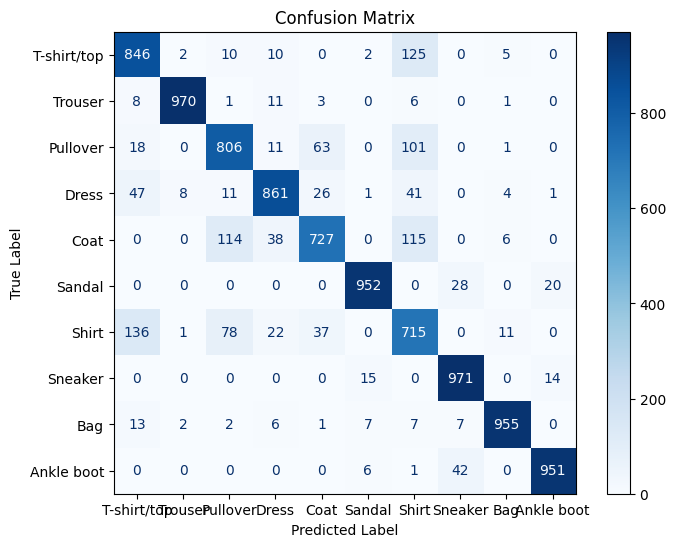

In [ ]:
y_test_label=[]
y_test_pred_label=[]
m=x_test.shape[0]
for i in range(m):
  x_tes =x_test[i,:].reshape(-1,1)
  a,h,y_test_pred=forward_prop(x_tes.T,theta1,'relu','softmax',4)
  y1=np.argmax(y_test[i,:].reshape(-1,1),axis=0)
  y_test_label.append(y1)
  # Get the index of the maximum probability for the current sample
  y2=np.argmax(y_test_pred)
  # Append only the predicted class label (integer) to the list
  y_test_pred_label.append(y2)
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Initialize W&B run
wandb.init(project='deep_learning_assignment_1', name='confusion_matrix_run')

# Compute confusion matrix
cm = confusion_matrix(y_test_label, y_test_pred_label)
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Log the confusion matrix plot to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()


In [ ]:
# question 8 : running a all the models for squared error loss and comapre them with previous one

In [ ]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs,'mse_loss')

try:
    wandb.agent(sweep_id,function=main,count=40)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: xbw7v2vr with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0826793753722251, Val Loss: 0.0828397645585575
Epoch 2, Train Loss: 0.07496900345762095, Val Loss: 0.07480291456366908
Epoch 3, Train Loss: 0.07387151995515015, Val Loss: 0.07349606482578785
Epoch 4, Train Loss: 0.06838005404065929, Val Loss: 0.06825629561269468
Epoch 5, Train Loss: 0.06762728167201656, Val Loss: 0.06751478115874418
Epoch 6, Train Loss: 0.06410060395608187, Val Loss: 0.0639392353467907
Epoch 7, Train Loss: 0.061751038529186134, Val Loss: 0.06229135646260592
Epoch 8, Train Loss: 0.061596250321579, Val Loss: 0.061926577885176325
Epoch 9, Train Loss: 0.06047981477874228, Val Loss: 0.06093226043167146
Epoch 10, Train Loss: 0.059264561425840925, Val Loss: 0.05993288769484555
Test Accuracy: 44.89


wandb: Agent Starting Run: 28q02ffl with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.18002321409129482, Validation Loss: 0.08671752904207276
Epoch 2, Loss: 0.17966489712617895, Validation Loss: 0.06986406536190089
Epoch 3, Loss: 0.17992728236774166, Validation Loss: 0.06330332912601831
Epoch 4, Loss: 0.1800521849463024, Validation Loss: 0.05972954556769737
Epoch 5, Loss: 0.17972188282468232, Validation Loss: 0.05665564260430892
Epoch 6, Loss: 0.18004881025994315, Validation Loss: 0.05379948473281937
Epoch 7, Loss: 0.17995759170254472, Validation Loss: 0.05319772078653219
Epoch 8, Loss: 0.1799581779650492, Validation Loss: 0.05135001942268513
Epoch 9, Loss: 0.18008725580859936, Validation Loss: 0.051424862447542546
Epoch 10, Loss: 0.17990686187685823, Validation Loss: 0.050134322778374554
Test accuracy: 0.7445


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,▇▁▅▇▂▇▆▆█▅
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.16852
train_loss,0.17991
val_accuracy,74.91667
val_loss,0.05013


wandb: Agent Starting Run: hy2hgtwe with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1 + np.exp(-x))


Epoch 1, Loss: 0.09052478313939143, Validation Loss: 0.09042888932093614
Epoch 2, Loss: 0.0912664738795614, Validation Loss: 0.0913561694341855
Epoch 3, Loss: 0.09095856937893715, Validation Loss: 0.09109280170576751
Epoch 4, Loss: 0.09088705554011528, Validation Loss: 0.09091178350656645
Epoch 5, Loss: 0.09064604223402704, Validation Loss: 0.09063534118371425
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▁▇█▁▁
train_loss,▁█▅▄▂
val_accuracy,█▂▁██
val_loss,▁█▆▅▃
epoch,5
train_accuracy,9.97963
train_loss,0.09065
val_accuracy,10.18333
val_loss,0.09064


wandb: Agent Starting Run: ojrxqw8o with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.09000325216477521, Val Loss: 0.090003609603209
Epoch 2, Train Loss: 0.09001619451206118, Val Loss: 0.09000844748929449
Epoch 3, Train Loss: 0.09000534504441114, Val Loss: 0.09000240585890297
Epoch 4, Train Loss: 0.09000832173737999, Val Loss: 0.09000659979417648
Epoch 5, Train Loss: 0.09000389413580262, Val Loss: 0.09001814660241973
Epoch 6, Train Loss: 0.09003505004826902, Val Loss: 0.0900673525865465
Epoch 7, Train Loss: 0.09001234099584994, Val Loss: 0.09002525889350298
Epoch 8, Train Loss: 0.0900016322572873, Val Loss: 0.09000880421388845
Epoch 9, Train Loss: 0.09003438425950469, Val Loss: 0.09001634447359891
Epoch 10, Train Loss: 0.09000682880835725, Val Loss: 0.09000936106881549
Test Accuracy: 10.01


wandb: Agent Starting Run: iekx6zj2 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.025426097947749037, Val Loss: 0.026499889783426475
Epoch 2, Train Loss: 0.017051709385382325, Val Loss: 0.01857879257405009
Epoch 3, Train Loss: 0.016674326406523665, Val Loss: 0.01834457701476395
Epoch 4, Train Loss: 0.014203280298219764, Val Loss: 0.016581691697753965
Epoch 5, Train Loss: 0.013623020821858215, Val Loss: 0.016417504397253254
Epoch 6, Train Loss: 0.01293533127590203, Val Loss: 0.01643537077381714
Epoch 7, Train Loss: 0.012326754130452543, Val Loss: 0.01610404177987172
Epoch 8, Train Loss: 0.015616790658080177, Val Loss: 0.019453922638585704
Epoch 9, Train Loss: 0.011427182304489504, Val Loss: 0.0158512712630786
Epoch 10, Train Loss: 0.011376867794805672, Val Loss: 0.01615541210944254
Test accuracy: 0.8818


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇█▆██
train_loss,█▄▄▂▂▂▁▃▁▁
val_accuracy,▁▆▆▇█▇█▆██
val_loss,█▃▃▁▁▁▁▃▁▁
epoch,10
train_accuracy,92.04815
train_loss,0.01138
val_accuracy,88.93333
val_loss,0.01616


wandb: Agent Starting Run: g6yenfre with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.0836880424439357, Val Loss: 0.08718668676893038
Epoch 2, Train Loss: 0.07366799992988667, Val Loss: 0.07785845103964933
Epoch 3, Train Loss: 0.06962699814179528, Val Loss: 0.07394833088190643
Epoch 4, Train Loss: 0.0673492410003614, Val Loss: 0.07089362843472599
Epoch 5, Train Loss: 0.06428275946754929, Val Loss: 0.06768409932291955
Test accuracy: 0.674


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,67.85
train_loss,0.06428
val_accuracy,66.15
val_loss,0.06768


wandb: Agent Starting Run: ah9xjgh5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.04869402997519229, Val Loss: 0.04950716994291966
Epoch 2, Train Loss: 0.042027024913280385, Val Loss: 0.04282798715278827
Epoch 3, Train Loss: 0.03906947472248024, Val Loss: 0.039857740108162086
Epoch 4, Train Loss: 0.03690385677566554, Val Loss: 0.03773413252296914
Epoch 5, Train Loss: 0.03535623272680991, Val Loss: 0.03624122613842856
Test Accuracy: 72.96000000000001


wandb: Agent Starting Run: 6tvcu5y3 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.12535501608781327, Validation Loss: 0.12462452125437985
Epoch 2, Loss: 0.17967580535677066, Validation Loss: 0.17867618128085608
Epoch 3, Loss: 0.17943769545206298, Validation Loss: 0.17843845098124644
Epoch 4, Loss: 0.18006659652238585, Validation Loss: 0.17906664495721247
Epoch 5, Loss: 0.1756086342073978, Validation Loss: 0.17466857314690332
Epoch 6, Loss: 0.17452994856277168, Validation Loss: 0.17355739354421051
Epoch 7, Loss: 0.15904286095209455, Validation Loss: 0.15817646404552044
Epoch 8, Loss: 0.17649266314928883, Validation Loss: 0.17550719950228408
Epoch 9, Loss: 0.12963997882588946, Validation Loss: 0.13009435543984288
Epoch 10, Loss: 0.12506032840034895, Validation Loss: 0.12587828135502926
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▁▁▁▁▁▁▁█▄
train_loss,▁███▇▇▅█▂▁
val_accuracy,▇███████▁▅
val_loss,▁███▇▇▅█▂▁
epoch,10
train_accuracy,10.01852
train_loss,0.12506
val_accuracy,9.83333
val_loss,0.12588


wandb: Agent Starting Run: ocybhfqh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13197855984223678, Validation Loss: 0.03236009031419731
Epoch 2, Loss: 0.1457310471702668, Validation Loss: 0.026147651829928377
Epoch 3, Loss: 0.1506379400317564, Validation Loss: 0.02376545272405695
Epoch 4, Loss: 0.1534373903355646, Validation Loss: 0.02241711010357468
Epoch 5, Loss: 0.15573884844867228, Validation Loss: 0.021450081014755894
Epoch 6, Loss: 0.1573809404565144, Validation Loss: 0.02135629061627474
Epoch 7, Loss: 0.1582569237039676, Validation Loss: 0.020284663334683428
Epoch 8, Loss: 0.15835839214475525, Validation Loss: 0.01988945936435812
Epoch 9, Loss: 0.1586150347215018, Validation Loss: 0.01975311359216739
Epoch 10, Loss: 0.15967613303503608, Validation Loss: 0.019376952756689207
Test accuracy: 0.8539


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,▁▄▆▆▇▇████
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,87.21111
train_loss,0.15968
val_accuracy,86.18333
val_loss,0.01938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lifoqhku with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02094182765654463, Val Loss: 0.021765771100858138
Epoch 2, Train Loss: 0.018811741261716107, Val Loss: 0.019781682714973253
Epoch 3, Train Loss: 0.01770261547552147, Val Loss: 0.01908941660936814
Epoch 4, Train Loss: 0.017297830067714105, Val Loss: 0.01910575519769458
Epoch 5, Train Loss: 0.016952187803319797, Val Loss: 0.018870453754110814
Epoch 6, Train Loss: 0.015749124508548363, Val Loss: 0.018219178493155793
Epoch 7, Train Loss: 0.014566190135681506, Val Loss: 0.01696812722177873
Epoch 8, Train Loss: 0.013512969640828055, Val Loss: 0.016785721339266143
Epoch 9, Train Loss: 0.013317261622389196, Val Loss: 0.01669094256742928
Epoch 10, Train Loss: 0.012947501448679727, Val Loss: 0.01659655106119821
Test accuracy: 0.8788


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▄▅▆▇██
train_loss,█▆▅▅▅▃▂▁▁▁
val_accuracy,▁▃▅▄▄▅▆▇██
val_loss,█▅▄▄▄▃▂▁▁▁
epoch,10
train_accuracy,91.0463
train_loss,0.01295
val_accuracy,88.61667
val_loss,0.0166


wandb: Agent Starting Run: dtla3aco with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 0.16252877096409524, Validation Loss: 0.02013634281603377
Epoch 2, Loss: 0.16377761761231052, Validation Loss: 0.020012834782029282
Epoch 3, Loss: 0.16211723923992713, Validation Loss: 0.020089958809650775
Epoch 4, Loss: 0.16623614604847686, Validation Loss: 0.018393727860499632
Epoch 5, Loss: 0.16506608800131822, Validation Loss: 0.017265439873486686
Test accuracy: 0.8692


epoch,▁▃▅▆█
train_accuracy,▁▂▃▆█
train_loss,▂▄▁█▆
val_accuracy,▁▂▂▇█
val_loss,███▄▁
epoch,5
train_accuracy,89.42778
train_loss,0.16507
val_accuracy,87.86667
val_loss,0.01727


wandb: Agent Starting Run: 2sn6zjdy with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.15949302671509796, Validation Loss: 0.019940719503337055
Epoch 2, Loss: 0.16206788427138963, Validation Loss: 0.02001565741967632
Epoch 3, Loss: 0.16227671440775346, Validation Loss: 0.01966471445010446
Epoch 4, Loss: 0.1655927413861693, Validation Loss: 0.01766197335311823
Epoch 5, Loss: 0.16483241870941517, Validation Loss: 0.017902906276569194
Test accuracy: 0.872


epoch,▁▃▅▆█
train_accuracy,▁▂▃▆█
train_loss,▁▄▄█▇
val_accuracy,▂▁▃█▇
val_loss,██▇▁▂
epoch,5
train_accuracy,89.58519
train_loss,0.16483
val_accuracy,87.6
val_loss,0.0179


wandb: Agent Starting Run: e79emf75 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.18003102852697134, Validation Loss: 0.17962360673091973
Epoch 2, Loss: 0.17929067891369257, Validation Loss: 0.17888619812640238
Epoch 3, Loss: 0.13624561198462917, Validation Loss: 0.13587418365228915
Epoch 4, Loss: 0.17996293863368454, Validation Loss: 0.18033330892170843
Epoch 5, Loss: 0.17695826505327283, Validation Loss: 0.1765452892265663
Epoch 6, Loss: 0.17995185184968526, Validation Loss: 0.18043333333118158
Epoch 7, Loss: 0.17981481481477765, Validation Loss: 0.18166666666662926
Epoch 8, Loss: 0.113413251830141, Validation Loss: 0.11420283019699433
Epoch 9, Loss: 0.17936334855143793, Validation Loss: 0.17858729652115032
Epoch 10, Loss: 0.1799518072049088, Validation Loss: 0.18043328849590443
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▂▂▄▂▄█▄▁▄
train_loss,██▃████▁██
val_accuracy,▇▇▇▅▇▅▁▅█▅
val_loss,██▃█▇██▁██
epoch,10
train_accuracy,10.02407
train_loss,0.17995
val_accuracy,9.78333
val_loss,0.18043


wandb: Agent Starting Run: 2jkh0noa with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08675888358596284, Val Loss: 0.08741961423797055
Epoch 2, Train Loss: 0.07230161728742437, Val Loss: 0.07333667436557162
Epoch 3, Train Loss: 0.06557340537483448, Val Loss: 0.06659979661440407
Epoch 4, Train Loss: 0.061674885459613964, Val Loss: 0.06293839884629893
Epoch 5, Train Loss: 0.05934852269952066, Val Loss: 0.06036651598893087
Test Accuracy: 52.39


wandb: Agent Starting Run: zkprbxft with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.021924985539436195, Val Loss: 0.022752541643788985
Epoch 2, Train Loss: 0.018968267775914698, Val Loss: 0.01991172577348237
Epoch 3, Train Loss: 0.017272754294628462, Val Loss: 0.01867664223144114
Epoch 4, Train Loss: 0.01722774143980869, Val Loss: 0.01915262436673792
Epoch 5, Train Loss: 0.01567187942433088, Val Loss: 0.01765000483175821
Test accuracy: 0.8675


epoch,▁▃▅▆█
train_accuracy,▁▄▆▆█
train_loss,█▅▃▃▁
val_accuracy,▁▅▇▆█
val_loss,█▄▂▃▁
epoch,5
train_accuracy,88.99815
train_loss,0.01567
val_accuracy,87.8
val_loss,0.01765


wandb: Agent Starting Run: 5sy1ywzc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.04226862598684814, Val Loss: 0.04370125085970933
Epoch 2, Train Loss: 0.04206794567248447, Val Loss: 0.043246230815050093
Epoch 3, Train Loss: 0.03796700438958907, Val Loss: 0.038879404585027755
Epoch 4, Train Loss: 0.03749054594402803, Val Loss: 0.03854097191028777
Epoch 5, Train Loss: 0.035902480149048316, Val Loss: 0.037572229410886546
Epoch 6, Train Loss: 0.03566922732894098, Val Loss: 0.037013001361472786
Epoch 7, Train Loss: 0.04085643847437393, Val Loss: 0.042055717514870895
Epoch 8, Train Loss: 0.03394943504282513, Val Loss: 0.03503490839623018
Epoch 9, Train Loss: 0.03347909529663773, Val Loss: 0.034975829018418815
Epoch 10, Train Loss: 0.031018153447541268, Val Loss: 0.03233067627781283
Test accuracy: 0.7662


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▃▄▅▂▇▆█
train_loss,██▅▅▄▄▇▃▃▁
val_accuracy,▁▃▃▃▄▅▁▇▆█
val_loss,██▅▅▄▄▇▃▃▁
epoch,10
train_accuracy,77.68148
train_loss,0.03102
val_accuracy,76.76667
val_loss,0.03233


wandb: Agent Starting Run: 0e927rsp with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.02153486215319355, Val Loss: 0.022435754952985453
Epoch 2, Train Loss: 0.01774378103835502, Val Loss: 0.019232680002214238
Epoch 3, Train Loss: 0.017510767351214793, Val Loss: 0.019177498615618998
Epoch 4, Train Loss: 0.01563078406060108, Val Loss: 0.01790886198277359
Epoch 5, Train Loss: 0.015397570349923555, Val Loss: 0.017830123418612672
Test accuracy: 0.8663


epoch,▁▃▅▆█
train_accuracy,▁▅▆██
train_loss,█▄▃▁▁
val_accuracy,▁▆▆██
val_loss,█▃▃▁▁
epoch,5
train_accuracy,89.21481
train_loss,0.0154
val_accuracy,87.45
val_loss,0.01783


wandb: Agent Starting Run: 3211tbjz with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.01921285617776834, Val Loss: 0.020262228769102993
Epoch 2, Train Loss: 0.018343787796224288, Val Loss: 0.019637304041461925
Epoch 3, Train Loss: 0.01759230227595161, Val Loss: 0.018959684564901002
Epoch 4, Train Loss: 0.01615567436033847, Val Loss: 0.018279936883877555
Epoch 5, Train Loss: 0.0144864375892241, Val Loss: 0.016867032938025737
Test accuracy: 0.8728


epoch,▁▃▅▆█
train_accuracy,▁▃▄▅█
train_loss,█▇▆▃▁
val_accuracy,▁▃▃▅█
val_loss,█▇▅▄▁
epoch,5
train_accuracy,89.80556
train_loss,0.01449
val_accuracy,88.63333
val_loss,0.01687


wandb: Agent Starting Run: yh08ystd with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14692734503490357, Validation Loss: 0.6411469311432916
Epoch 2, Loss: 0.15126525168803318, Validation Loss: 0.5649969994614404
Epoch 3, Loss: 0.15338036665484786, Validation Loss: 0.5376249421982972
Epoch 4, Loss: 0.15484047720898408, Validation Loss: 0.5068758587199567
Epoch 5, Loss: 0.15565284843568106, Validation Loss: 0.49127104842042363
Epoch 6, Loss: 0.15719924215622152, Validation Loss: 0.48306518375190366
Epoch 7, Loss: 0.15676746629037233, Validation Loss: 0.47840597653983136
Epoch 8, Loss: 0.15772770342930223, Validation Loss: 0.4641903483311318
Epoch 9, Loss: 0.15851894923615542, Validation Loss: 0.4546053148534458
Epoch 10, Loss: 0.15865927133083163, Validation Loss: 0.4468421324929427
 accuracy: 0.8286


wandb: Agent Starting Run: 9dk9zvn1 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.059823075525469054, Val Loss: 0.06113025850342994
Epoch 2, Train Loss: 0.05096868440583515, Val Loss: 0.05154238254125775
Epoch 3, Train Loss: 0.04277028615869221, Val Loss: 0.04370807954094446
Epoch 4, Train Loss: 0.04431570158643021, Val Loss: 0.04539186839225124
Epoch 5, Train Loss: 0.06005798975648713, Val Loss: 0.060529092793686214
Test accuracy: 0.5263


epoch,▁▃▅▆█
train_accuracy,▃▃▇█▁
train_loss,█▄▁▂█
val_accuracy,▃▄▇█▁
val_loss,█▄▁▂█
epoch,5
train_accuracy,52.78704
train_loss,0.06006
val_accuracy,52.08333
val_loss,0.06053


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9vvxwlcm with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.08973580407070877, Val Loss: 0.08975045305046263
Epoch 2, Train Loss: 0.08945094999631592, Val Loss: 0.08946852634206276
Epoch 3, Train Loss: 0.08909106993200973, Val Loss: 0.08912023145126173
Epoch 4, Train Loss: 0.08857213594581319, Val Loss: 0.08860017263876456
Epoch 5, Train Loss: 0.08774778979024925, Val Loss: 0.08779435042293081
Epoch 6, Train Loss: 0.0863970877509716, Val Loss: 0.08645842249469168
Epoch 7, Train Loss: 0.08408602544233239, Val Loss: 0.08418075871081518
Epoch 8, Train Loss: 0.08063073431341347, Val Loss: 0.08078311261293998
Epoch 9, Train Loss: 0.07646156258607907, Val Loss: 0.07667994350928138
Epoch 10, Train Loss: 0.07254283837750386, Val Loss: 0.07278065533392875
Test Accuracy: 50.32


wandb: Agent Starting Run: l1dtuowf with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.01967321160808731, Val Loss: 0.02094712028696796
Epoch 2, Train Loss: 0.017966966994607873, Val Loss: 0.019357111907980125
Epoch 3, Train Loss: 0.01838034750328821, Val Loss: 0.020786806356504935
Epoch 4, Train Loss: 0.016042716054080478, Val Loss: 0.018653974515640447
Epoch 5, Train Loss: 0.013855206615312907, Val Loss: 0.01697513379971313
Epoch 6, Train Loss: 0.013366757606611003, Val Loss: 0.017083115109143353
Epoch 7, Train Loss: 0.012808875856619013, Val Loss: 0.016913324941998112
Epoch 8, Train Loss: 0.013152446956629149, Val Loss: 0.01757931641054921
Epoch 9, Train Loss: 0.011125865237376503, Val Loss: 0.016225691812045837
Epoch 10, Train Loss: 0.010988983500961495, Val Loss: 0.01568242976959169
Test accuracy: 0.8846


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▄▆▆▇▆██
train_loss,█▇▇▅▃▃▂▃▁▁
val_accuracy,▁▃▂▅▆▆▇▅██
val_loss,█▆█▅▃▃▃▄▂▁
epoch,10
train_accuracy,92.22037
train_loss,0.01099
val_accuracy,89.25
val_loss,0.01568


wandb: Agent Starting Run: oomngglv with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.019400405113718953, Val Loss: 0.02048245395424866
Epoch 2, Train Loss: 0.01713517848768843, Val Loss: 0.01857299227846812
Epoch 3, Train Loss: 0.015911058664996564, Val Loss: 0.017811824346449054
Epoch 4, Train Loss: 0.013993237657236477, Val Loss: 0.016452210292880694
Epoch 5, Train Loss: 0.013643546895804772, Val Loss: 0.016150477048810064
Epoch 6, Train Loss: 0.013513075586474986, Val Loss: 0.01671671947402096
Epoch 7, Train Loss: 0.011843248394233813, Val Loss: 0.015651052413107536
Epoch 8, Train Loss: 0.01155175308872502, Val Loss: 0.01615049538613931
Epoch 9, Train Loss: 0.011480017003988608, Val Loss: 0.016240202359246787
Epoch 10, Train Loss: 0.01075944848538, Val Loss: 0.01595115507390142
Test accuracy: 0.8842


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▄▅▆▇▇█▇█▇
val_loss,█▅▄▂▂▃▁▂▂▁
epoch,10
train_accuracy,92.6
train_loss,0.01076
val_accuracy,88.76667
val_loss,0.01595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5kej6iyn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13463285088675783, Validation Loss: 0.032906886169408
Epoch 2, Loss: 0.14931556937285725, Validation Loss: 0.026401337467223278
Epoch 3, Loss: 0.15369129318971225, Validation Loss: 0.02311874463508396
Epoch 4, Loss: 0.15774432608642164, Validation Loss: 0.021198479857582865
Epoch 5, Loss: 0.16028667590260195, Validation Loss: 0.020764633165018885
Test accuracy: 0.8493


epoch,▁▃▅▆█
train_accuracy,▁▄▇██
train_loss,▁▅▆▇█
val_accuracy,▁▄▇██
val_loss,█▄▂▁▁
epoch,5
train_accuracy,86.73519
train_loss,0.16029
val_accuracy,85.6
val_loss,0.02076


wandb: Agent Starting Run: nd4jwlw1 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.03372452613455897, Val Loss: 0.03487913514510839
Epoch 2, Train Loss: 0.025611358752502426, Val Loss: 0.026600490215819724
Epoch 3, Train Loss: 0.022525484119644654, Val Loss: 0.023755194655793562
Epoch 4, Train Loss: 0.020638492877591747, Val Loss: 0.02174399399124132
Epoch 5, Train Loss: 0.01989008971201433, Val Loss: 0.021076976357728778
Epoch 6, Train Loss: 0.019182059047430026, Val Loss: 0.020562172793276427
Epoch 7, Train Loss: 0.018346921062325085, Val Loss: 0.019829167776269377
Epoch 8, Train Loss: 0.01785818471513056, Val Loss: 0.019418881919678603
Epoch 9, Train Loss: 0.017440282839369665, Val Loss: 0.01915852171461736
Epoch 10, Train Loss: 0.017254718021919885, Val Loss: 0.019156209632721344
Test accuracy: 0.8581


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,88.07222
train_loss,0.01725
val_accuracy,86.73333
val_loss,0.01916


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vsp6fnz5 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.1724855939674157, Validation Loss: 0.15906026781343657
Epoch 2, Loss: 0.15306578859667805, Validation Loss: 0.1491262041579407
Epoch 3, Loss: 0.17892407658870385, Validation Loss: 0.17863007456112398
Epoch 4, Loss: 0.1797302618129361, Validation Loss: 0.1787322308055252
Epoch 5, Loss: 0.15733038330223464, Validation Loss: 0.15692468826203104
Epoch 6, Loss: 0.15456994281359462, Validation Loss: 0.15492169040461626
Epoch 7, Loss: 0.17925138911429428, Validation Loss: 0.1785510841733834
Epoch 8, Loss: 0.14116919996237598, Validation Loss: 0.1406080735469525
Epoch 9, Loss: 0.1797519051205346, Validation Loss: 0.1816032345837134
Epoch 10, Loss: 0.17988586054550373, Validation Loss: 0.18036730376759863
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,▇▃██▄▃█▁██
val_accuracy,█▁▂▂▂▂▂▂▁▁
val_loss,▄▂▇█▄▃▇▁██
epoch,10
train_accuracy,10.02407
train_loss,0.17989
val_accuracy,9.78333
val_loss,0.18037


wandb: Agent Starting Run: 65sn4v0x with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.020363742012777065, Val Loss: 0.021237285206216545
Epoch 2, Train Loss: 0.01879422408276671, Val Loss: 0.020351431876248202
Epoch 3, Train Loss: 0.016853377119216556, Val Loss: 0.0188117711752366
Epoch 4, Train Loss: 0.015702323929295704, Val Loss: 0.017967475962497634
Epoch 5, Train Loss: 0.01592200574143795, Val Loss: 0.018543038158248
Test Accuracy: 86.00999999999999


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6lsbrbuk with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.028280062832082106, Val Loss: 0.028993683756821022
Epoch 2, Train Loss: 0.024535018874534582, Val Loss: 0.02512791942912942
Epoch 3, Train Loss: 0.022861820818019695, Val Loss: 0.02343637692750013
Epoch 4, Train Loss: 0.021905741935964687, Val Loss: 0.02255520358600386
Epoch 5, Train Loss: 0.021287632588634267, Val Loss: 0.021856514838251677
Test Accuracy: 83.65


wandb: Agent Starting Run: 6wj6zva5 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.025498796498607253, Val Loss: 0.02620404337507596
Epoch 2, Train Loss: 0.020762994293273676, Val Loss: 0.021623591931874533
Epoch 3, Train Loss: 0.01933541340549939, Val Loss: 0.020383478648079427
Epoch 4, Train Loss: 0.017677567740419002, Val Loss: 0.018861586900679822
Epoch 5, Train Loss: 0.017909636566724396, Val Loss: 0.01924830072988588
Epoch 6, Train Loss: 0.01794838462528112, Val Loss: 0.019254205815772862
Epoch 7, Train Loss: 0.017442943288216783, Val Loss: 0.01930311258890196
Epoch 8, Train Loss: 0.015873240233682386, Val Loss: 0.017721372269653445
Epoch 9, Train Loss: 0.017092392578783165, Val Loss: 0.019379705259337014
Epoch 10, Train Loss: 0.016001437198976648, Val Loss: 0.018498373609720717
Test accuracy: 0.8622


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▅▇▇▇▇█▇█
train_loss,█▅▄▂▂▃▂▁▂▁
val_accuracy,▁▅▅▇▆▆▆█▆▇
val_loss,█▄▃▂▂▂▂▁▂▂
epoch,10
train_accuracy,88.70556
train_loss,0.016
val_accuracy,87.16667
val_loss,0.0185


wandb: Agent Starting Run: 2e7s1jd6 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.030703827930308507, Val Loss: 0.031786654559186854
Epoch 2, Train Loss: 0.02637733720867672, Val Loss: 0.027470010074178645
Epoch 3, Train Loss: 0.02462483033665985, Val Loss: 0.025841459921202455
Epoch 4, Train Loss: 0.023530235909412226, Val Loss: 0.024782945733767804
Epoch 5, Train Loss: 0.022440233348477185, Val Loss: 0.02426978898231028
Epoch 6, Train Loss: 0.021778977054862814, Val Loss: 0.023566063420547522
Epoch 7, Train Loss: 0.021108817527060095, Val Loss: 0.02313322895909753
Epoch 8, Train Loss: 0.02099667577081971, Val Loss: 0.022861714266964348
Epoch 9, Train Loss: 0.02014999696723962, Val Loss: 0.022467129046877705
Epoch 10, Train Loss: 0.019619717786032092, Val Loss: 0.022193397251629405
Test accuracy: 0.8335


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,86.22778
train_loss,0.01962
val_accuracy,84.5
val_loss,0.02219


wandb: Agent Starting Run: jb6scypn with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 0.02814843187583602, Val Loss: 0.029382047132523386
Epoch 2, Train Loss: 0.024060378327072068, Val Loss: 0.025731441332781393
Epoch 3, Train Loss: 0.02193885981830049, Val Loss: 0.024167819626830015
Epoch 4, Train Loss: 0.020853342521889487, Val Loss: 0.02383715347738418
Epoch 5, Train Loss: 0.020119238735589486, Val Loss: 0.02315102427888552
Epoch 6, Train Loss: 0.0190636908065289, Val Loss: 0.02260465361038498
Epoch 7, Train Loss: 0.01809298254438605, Val Loss: 0.022192552533622078
Epoch 8, Train Loss: 0.0176181077251856, Val Loss: 0.021911567240724128
Epoch 9, Train Loss: 0.01719180444587475, Val Loss: 0.0217634082279412
Epoch 10, Train Loss: 0.016485754508658915, Val Loss: 0.021282533370537864
Test accuracy: 0.8445


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▅▃▃▃▂▂▂▁▁
epoch,10
train_accuracy,88.36667
train_loss,0.01649
val_accuracy,84.96667
val_loss,0.02128


wandb: Agent Starting Run: at4m2ldy with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.14934817025416003, Validation Loss: 0.03033444805637599
Epoch 2, Loss: 0.15505691197991658, Validation Loss: 0.02667703250571897
Epoch 3, Loss: 0.15794307339765065, Validation Loss: 0.02447305706392511
Epoch 4, Loss: 0.15910144093783357, Validation Loss: 0.023981767368092086
Epoch 5, Loss: 0.160369078589808, Validation Loss: 0.02276390232436238
Test accuracy: 0.8343


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,▁▅▆▇█
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,85.2463
train_loss,0.16037
val_accuracy,84.21667
val_loss,0.02276


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tv17ddsu with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.09038892142750193, Validation Loss: 0.0903444903196418
Epoch 2, Loss: 0.09020239918755736, Validation Loss: 0.09014408391282791
Epoch 3, Loss: 0.09043814648134016, Validation Loss: 0.09056525640084342
Epoch 4, Loss: 0.0902762453374786, Validation Loss: 0.09025016679072308
Epoch 5, Loss: 0.0903436486243412, Validation Loss: 0.0902250869459035
Epoch 6, Loss: 0.09012606555694905, Validation Loss: 0.09008727029191098
Epoch 7, Loss: 0.0902188083506106, Validation Loss: 0.09020041832776668
Epoch 8, Loss: 0.09037316030541487, Validation Loss: 0.09032688092923767
Epoch 9, Loss: 0.09017243547481034, Validation Loss: 0.09011920664667156
Epoch 10, Loss: 0.09012341280554123, Validation Loss: 0.0900771528839132
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▃█▁▂▂▂▄▁▄
train_loss,▇▃█▄▆▁▃▇▂▁
val_accuracy,▆▆▁█▇▇▇▅█▅
val_loss,▅▂█▃▃▁▃▅▂▁
epoch,10
train_accuracy,10.01852
train_loss,0.09012
val_accuracy,9.83333
val_loss,0.09008


wandb: Agent Starting Run: yp3ut563 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 0.15535173885977527, Validation Loss: 0.025557933335534095
Epoch 2, Loss: 0.15672318739770422, Validation Loss: 0.022398006943027685
Epoch 3, Loss: 0.1588526212826964, Validation Loss: 0.02080227662625705
Epoch 4, Loss: 0.16112924540792498, Validation Loss: 0.020170234576765204
Epoch 5, Loss: 0.1610469078534225, Validation Loss: 0.019261451660167638
Epoch 6, Loss: 0.16320910764973598, Validation Loss: 0.01877100250241228
Epoch 7, Loss: 0.16371028276344568, Validation Loss: 0.01816949092702936
Epoch 8, Loss: 0.16299000684856357, Validation Loss: 0.018346775059281617
Epoch 9, Loss: 0.163748043024429, Validation Loss: 0.01816989703460286
Epoch 10, Loss: 0.16371415406860285, Validation Loss: 0.018382180048433883
Test accuracy: 0.8608


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇████
train_loss,▁▂▄▆▆██▇██
val_accuracy,▁▃▅▆▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
train_accuracy,88.38333
train_loss,0.16371
val_accuracy,87.45
val_loss,0.01838


wandb: Agent Starting Run: a0waanyh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.05305794752959299, Val Loss: 0.0547055421432119
Epoch 2, Train Loss: 0.04467219932713539, Val Loss: 0.04609151346799834
Epoch 3, Train Loss: 0.04078690694856481, Val Loss: 0.04208422446496078
Epoch 4, Train Loss: 0.03813949813553586, Val Loss: 0.03961930510429734
Epoch 5, Train Loss: 0.03663800521914711, Val Loss: 0.03803282740562549
Epoch 6, Train Loss: 0.03516267847529188, Val Loss: 0.03693161390079052
Epoch 7, Train Loss: 0.03384884612468231, Val Loss: 0.03584333853911485
Epoch 8, Train Loss: 0.033109969272709705, Val Loss: 0.03515002140058142
Epoch 9, Train Loss: 0.032174697068478184, Val Loss: 0.03410533200772146
Epoch 10, Train Loss: 0.031617655243515196, Val Loss: 0.03389261380116153
Test accuracy: 0.7522


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,77.36481
train_loss,0.03162
val_accuracy,75.66667
val_loss,0.03389


wandb: Agent Starting Run: 7ir2j816 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 10]
Epoch 1, Loss: 0.13839949892023873, Validation Loss: 0.13850685263737103
Epoch 2, Loss: 0.17301978951148647, Validation Loss: 0.17278858078980872
Epoch 3, Loss: 0.179407342299911, Validation Loss: 0.1791159257118939
Epoch 4, Loss: 0.17262057504059022, Validation Loss: 0.1729847783777505
Epoch 5, Loss: 0.12613345616807242, Validation Loss: 0.12598973918917342
Epoch 6, Loss: 0.1498961641278722, Validation Loss: 0.1492650269278199
Epoch 7, Loss: 0.17905995570703748, Validation Loss: 0.178761453331121
Epoch 8, Loss: 0.148765808236469, Validation Loss: 0.1485464845423385
Epoch 9, Loss: 0.12420299077126075, Validation Loss: 0.12452376564002769
Epoch 10, Loss: 0.11748205805325711, Validation Loss: 0.11776312650818457
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁███▇▇████
train_loss,▃▇█▇▂▅█▅▂▁
val_accuracy,▁▅▅▁▆█▅▅▃▅
val_loss,▃▇█▇▂▅█▅▂▁
epoch,10
train_accuracy,9.98519
train_loss,0.11748
val_accuracy,10.13333
val_loss,0.11776


wandb: Agent Starting Run: zpxpwj12 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:20: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x,axis=1,keepdims=True)


Epoch 1, Loss: nan, Validation Loss: nan
Epoch 2, Loss: nan, Validation Loss: nan
Epoch 3, Loss: nan, Validation Loss: nan
Epoch 4, Loss: nan, Validation Loss: nan
Epoch 5, Loss: nan, Validation Loss: nan
Epoch 6, Loss: nan, Validation Loss: nan
Epoch 7, Loss: nan, Validation Loss: nan
Epoch 8, Loss: nan, Validation Loss: nan
Epoch 9, Loss: nan, Validation Loss: nan
Epoch 10, Loss: nan, Validation Loss: nan
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: 9qy5zzua with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.023402130635453666, Val Loss: 0.024311250978709616
Epoch 2, Train Loss: 0.019367591084905864, Val Loss: 0.02033448946067587
Epoch 3, Train Loss: 0.01850376414114034, Val Loss: 0.01975258638269242
Epoch 4, Train Loss: 0.01752157922956936, Val Loss: 0.01937060598017987
Epoch 5, Train Loss: 0.0162542151113874, Val Loss: 0.0183001566685873
Test accuracy: 0.8635


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▆▆▇█
val_loss,█▃▃▂▁
epoch,5
train_accuracy,88.67037
train_loss,0.01625
val_accuracy,87.36667
val_loss,0.0183


wandb: Agent Starting Run: nzabznsc with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.03153371378769183, Val Loss: 0.03232628952685628
Epoch 2, Train Loss: 0.027623224974935887, Val Loss: 0.02838053815375849
Epoch 3, Train Loss: 0.025538083684963676, Val Loss: 0.026922720660781628
Epoch 4, Train Loss: 0.024418083938117775, Val Loss: 0.025999338489116557
Epoch 5, Train Loss: 0.023685929419030652, Val Loss: 0.025412236601029297
Epoch 6, Train Loss: 0.02288049201540435, Val Loss: 0.024828397066276174
Epoch 7, Train Loss: 0.022285739398344044, Val Loss: 0.02425477320132096
Epoch 8, Train Loss: 0.021625764767441387, Val Loss: 0.023754696799432748
Epoch 9, Train Loss: 0.021334646623412824, Val Loss: 0.02350316100020739
Epoch 10, Train Loss: 0.021015176657537726, Val Loss: 0.022974497485068315
Test accuracy: 0.8281


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,85.15556
train_loss,0.02102
val_accuracy,83.78333
val_loss,0.02297


wandb: Agent Starting Run: sok4znvh with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.12496333735049983, Validation Loss: 0.91768380945845
Epoch 2, Loss: 0.13652955215540094, Validation Loss: 0.7005063410632925
Epoch 3, Loss: 0.14865221676925458, Validation Loss: 0.5189934410091203
Epoch 4, Loss: 0.15511243515238576, Validation Loss: 0.4558383029617519
Epoch 5, Loss: 0.15622939042610665, Validation Loss: 0.4293738441698732
Epoch 6, Loss: 0.15780663306761541, Validation Loss: 0.4056539057177651
Epoch 7, Loss: 0.15978209124026563, Validation Loss: 0.4283074478111444
Epoch 8, Loss: 0.1605777948930568, Validation Loss: 0.4054496005621632
Epoch 9, Loss: 0.16142938055545672, Validation Loss: 0.3873139468634437
Epoch 10, Loss: 0.16132195482723394, Validation Loss: 0.37938014327349945
 accuracy: 0.8616


In [ ]:
#Q 10 : download the mnist dataset and run this data set of three recomendation of best models obtain after hyper parameter search.


In [75]:
from keras.datasets import mnist
(train_x1,train_y1),(test_x1,test_y1)=mnist.load_data()

x1_train,y1_train,x1_val,y1_val,x1_test,y_test=tranform_dataset(train_x1,train_y1,test_x1,test_y1)

In [87]:
#  optimizer redefined for recommendation and see the accuracy (code is almost same as before only here i remove the wandb log)
def re_mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")



    print(f'Validation accuracy: {validation_accuracy*100}')
    return theta

def re_adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss},Validation acuuracy:{validation_accuracy}")

    print(f'Validation accuracy: {validation_accuracy*100}')
    return theta



def re_nadam(lr, beta1, beta2, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss},Validation acuuracy:{validation_accuracy}")


    print(f'Training accuracy: {train_accuracy*100}')
    print(f'Validation accuracy: {validation_accuracy*100}')

    return theta




In [89]:
#1st recomendation

theta=re_nadam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,64,5,64,'relu','softmax','Xavier',0,10)

[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 8.976133395654726, Validation Loss: 0.1511022798055648,Validation acuuracy:0.9558333333333333
Epoch 2, Loss: 10.641843708560577, Validation Loss: 0.1054675573068786,Validation acuuracy:0.9678333333333333
Epoch 3, Loss: 11.612914306729044, Validation Loss: 0.11063386202052453,Validation acuuracy:0.9651666666666666
Epoch 4, Loss: 12.07860528743294, Validation Loss: 0.08969206395331672,Validation acuuracy:0.975
Epoch 5, Loss: 13.668289047061473, Validation Loss: 0.09347032927661313,Validation acuuracy:0.973
Epoch 6, Loss: 14.64050957065347, Validation Loss: 0.09285336203942426,Validation acuuracy:0.9745
Epoch 7, Loss: 15.046985384588792, Validation Loss: 0.0971923258737286,Validation acuuracy:0.974
Epoch 8, Loss: 16.201484170310092, Validation Loss: 0.10434700643875086,Validation acuuracy:0.9733333333333334
Epoch 9, Loss: 16.658498151544794, Validation Loss: 0.10002283921119488,Validation acuuracy:0.9741666666666666
Epoch 10, Loss: 18.295472926

In [85]:
#2nd recomendation

theta=re_adam(0.001,0.9,0.99,1e-8,x1_train,y1_train,x1_val,y1_val,64,5,64,'relu','softmax','Xavier',0,10)

[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.1293963317743927, Val Loss: 0.14559807296171165,Validation acuuracy:0.9575
Epoch 2, Train Loss: 0.08594499051578319, Val Loss: 0.11275851221430186,Validation acuuracy:0.9636666666666667
Epoch 3, Train Loss: 0.07821153001438139, Val Loss: 0.11336739258249706,Validation acuuracy:0.9655
Epoch 4, Train Loss: 0.05094498462011537, Val Loss: 0.09568946625128905,Validation acuuracy:0.9725
Epoch 5, Train Loss: 0.04582583829057265, Val Loss: 0.09241338048542128,Validation acuuracy:0.9738333333333333
Epoch 6, Train Loss: 0.041696247234120624, Val Loss: 0.09840150260994136,Validation acuuracy:0.9706666666666667
Epoch 7, Train Loss: 0.02585241605081825, Val Loss: 0.08652995392276348,Validation acuuracy:0.9755
Epoch 8, Train Loss: 0.022948746316367414, Val Loss: 0.09531410693932017,Validation acuuracy:0.9748333333333333
Epoch 9, Train Loss: 0.023371997564286984, Val Loss: 0.09924389480317719,Validation acuuracy:0.9743333333333334
Epoch 10, Train L

In [86]:
#3rd recomendation

theta=re_mgd(0.001,0.9,x1_train,y1_train,x1_val,y1_val,32,5,32,'relu','softmax','Xavier',0,10)

[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.25193830441955956, Val Loss: 0.2628768819530346,Validation acuuracy:0.9298333333333333
Epoch 2, Train Loss: 0.18896075955956018, Val Loss: 0.21421743302177948,Validation acuuracy:0.943
Epoch 3, Train Loss: 0.16750097690447072, Val Loss: 0.18984333279095486,Validation acuuracy:0.9485
Epoch 4, Train Loss: 0.13857200435470787, Val Loss: 0.16109399679612568,Validation acuuracy:0.9558333333333333
Epoch 5, Train Loss: 0.11976370778902135, Val Loss: 0.15592522664790662,Validation acuuracy:0.9593333333333334
Epoch 6, Train Loss: 0.12388340639031327, Val Loss: 0.16729131457503313,Validation acuuracy:0.9565
Epoch 7, Train Loss: 0.11329036697525828, Val Loss: 0.14602631484105363,Validation acuuracy:0.9588333333333333
Epoch 8, Train Loss: 0.12388561520271561, Val Loss: 0.15866931001404638,Validation acuuracy:0.96
Epoch 9, Train Loss: 0.12066509480264347, Val Loss: 0.17031282761583386,Validation acuuracy:0.9561666666666667
Epoch 10, Train Loss: 0

IndexError: arrays used as indices must be of integer (or boolean) type